# Multi-Asset Portfolio Optimization with Dynamic Risk Management

**Author:** Aymen Hafsaoui
**Date:** December 2025
----

## Project Overview

**Objective:** Build an optimized multi asset portfolio with regime based dynamic risk management

**Key Features:**
- 37 assets across equities, bonds, commodities and currencies
- Markov switching GARCH volatility forecasting
- Constrained mean-variance optimization
- Two-state momentum strategy for dynamic risk management
- Walk-forward backtesting (2020-2025)

**Results:**
- Training Sharpe: 1.193 (2010-2020)
- Test Sharpe: 0.971 (2020-2025)
- Benchmark Sharpe: 0.763 (S&P 500)
- **+27.3% improvement over benchmark**

**Technology Stack:** Python, pandas, statsmodels, scipy, arch, yfinance

---

## Notebook Structure

1. **Module 1:** Data Collection (37 assets)
2. **Module 2:** Exploratory Data Analysis
3. **Module 3:** Stationarity Testing
4. **Module 4:** Volatility Forecasting (Markov-GARCH)
5. **Module 5:** Portfolio Optimization (Sharpe maximization)
6. **Module 6:** Dynamic Backtesting (Two-state strategy)


# 0- Importing Libraries

In [1]:
! pip install arch -q
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from scipy.optimize import differential_evolution
import warnings
warnings.filterwarnings('ignore')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 27.2 MB/s eta 0:00:00


# 1- Asset Selection and Download Data
##  Rationale:
The asset universe contains 37 assets from various classes in order to achieve optimal diversification:
- Equities 60%: Large cap tech (AAPL, MSFT, GOOGL), Growth stocks(AMZN, TSLA, NVDA, META),international exposure (^HSI) and established companies (JNJ, PG, KO, PEP, WMT, MCD, NKE, DIS, CSCO, INTC, IBM, MRK, CVX, XOM)
- Fixed Income 20%: U.S. Treasury bonds with different maturities (TLT 20+ year, IEF 7-10 year) and international bonds (BNDX)
- Real Assets 15%:  Gold (GC=F), crude oil (CL=F) and real estate (VNQ) offer inflation protection and additional diversification
- Currency 5%: Major pairs (EURUSD=X, GBPUSD=X, JPYUSD=X) provide exposure to global macro trends

 The selected training period (2010-2020) includes multiple market states such as COVID's market crisis in 2020. The backtest period (2020 - 2025) contains pandemic market crash and recovery, inflation surge for a decent out of sample validation.

 1 month gap between both periods to prevent data leakage





[*********************100%***********************]  37 of 37 completed


Data: 2759 days, 37 assets
Date range: 2010-01-04 to 2020-07-30
Descriptive Statistics:
Ticker         AAPL          AMD         AMZN     AUDUSD=X          BAC  \
count   2759.000000  2759.000000  2759.000000  2759.000000  2759.000000   
mean       0.001117     0.001391     0.001324    -0.000059     0.000454   
std        0.017091     0.035942     0.019563     0.006736     0.022056   
min       -0.128647    -0.242291    -0.126568    -0.040426    -0.203182   
25%       -0.006550    -0.015947    -0.007821    -0.003831    -0.009527   
50%        0.000390     0.000000     0.000538     0.000087     0.000000   
75%        0.009718     0.017564     0.010985     0.003884     0.010479   
max        0.119808     0.522901     0.157457     0.028944     0.177962   

Ticker         BNDX            C         CSCO     EURUSD=X     GBPUSD=X  ...  \
count   2759.000000  2759.000000  2759.000000  2759.000000  2759.000000  ...   
mean       0.000109     0.000428     0.000469    -0.000056    -0.000063  ...

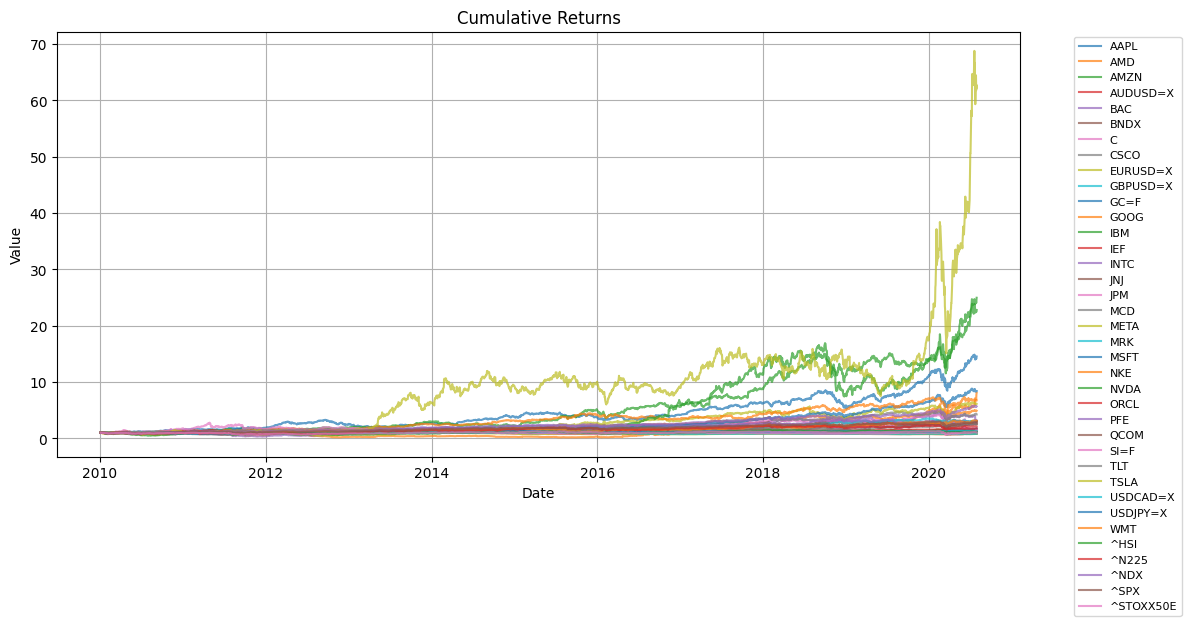

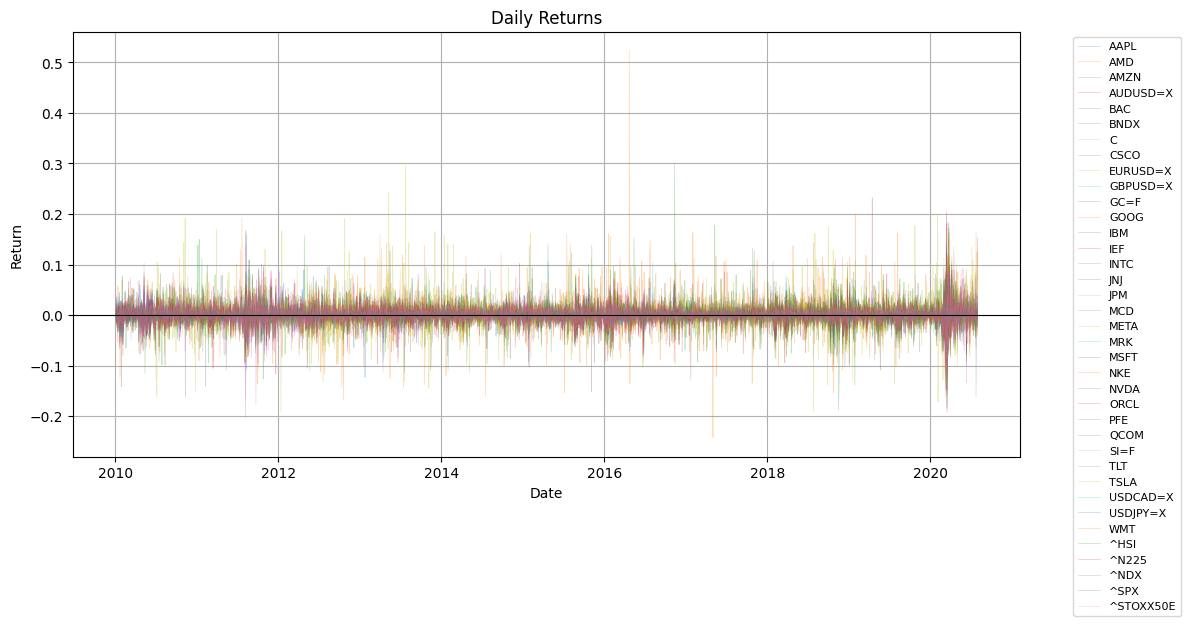

In [2]:
# Asset universe

assets = [
    # Stocks
    "AAPL", "MSFT", "GOOG", "AMZN", "META", "NVDA", "TSLA", "ORCL", "IBM",
    "INTC", "AMD", "CSCO", "QCOM", "JNJ", "PFE", "MRK", "JPM", "BAC", "C",
    "NKE", "MCD", "WMT",

    # Currencies
    "EURUSD=X", "GBPUSD=X", "USDJPY=X", "AUDUSD=X", "USDCAD=X",

    # Indices
    "^SPX", "^NDX", "^STOXX50E", "^N225", "^HSI",

    # Commodities
    "GC=F", "SI=F",

    # Bonds
    "TLT", "IEF", "BNDX"
]

# Download data

prices = yf.download(assets, start='2010-01-01', end='2020-07-31')['Close']

# Clean data (fill missing values)

prices = prices.ffill().bfill()  # Forward fill then backward fill

# Returns (Prices are not stationary)

returns = prices.pct_change().dropna()  # Daily returns

print(f"Data: {returns.shape[0]} days, {returns.shape[1]} assets")
print(f"Date range: {returns.index[0].date()} to {returns.index[-1].date()}")


# Descriptive Statistics

print("Descriptive Statistics:")
print(returns.describe())

# plot cumulative returns
cum_returns = (1 + returns).cumprod()
plt.figure(figsize=(12, 6))
for asset in cum_returns.columns:
    plt.plot(cum_returns.index, cum_returns[asset], label=asset, alpha=0.7)
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

# daily returns

plt.figure(figsize=(12, 6))
for asset in returns.columns:
    plt.plot(returns.index, returns[asset], label=asset, alpha=0.3, linewidth=0.5)
plt.title('Daily Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.axhline(y=0, color='black', linewidth=0.8)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

#2- Exploratory Analysis of Returns:

Return Distribution Analysis

Skewness (asymmetry):
Ticker
BNDX        -2.318893
GBPUSD=X    -0.929352
SI=F        -0.742407
^SPX        -0.573302
GC=F        -0.463381
IBM         -0.438297
^NDX        -0.411621
^STOXX50E   -0.351171
^N225       -0.310293
^HSI        -0.268659
CSCO        -0.245815
JNJ         -0.235200
C           -0.233137
AUDUSD=X    -0.153923
AAPL        -0.145205
EURUSD=X    -0.058424
INTC        -0.049357
IEF         -0.028345
BAC         -0.019482
PFE          0.009848
TLT          0.057403
JPM          0.071167
MSFT         0.078026
USDJPY=X     0.150244
MRK          0.164862
USDCAD=X     0.180701
QCOM         0.236358
ORCL         0.314472
AMZN         0.401577
TSLA         0.496751
NKE          0.535110
MCD          0.554707
WMT          0.595575
NVDA         0.635443
GOOG         0.654403
AMD          1.169283
META         1.178994
dtype: float64

Kurtosis (fat tails):
Ticker
MCD          38.759550
BNDX         34.415393
META         27.809928
AMD          

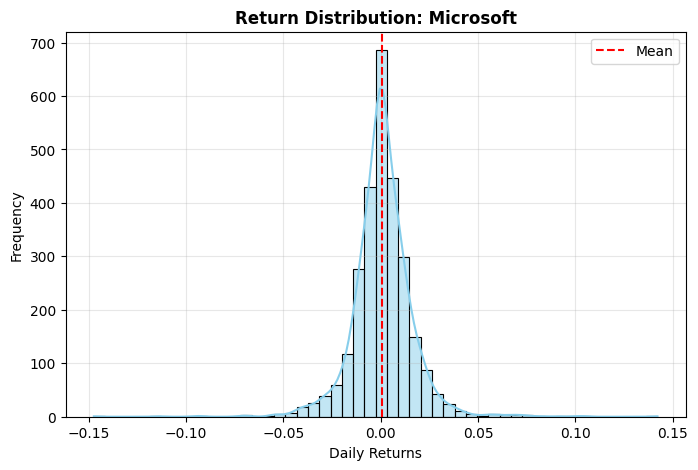

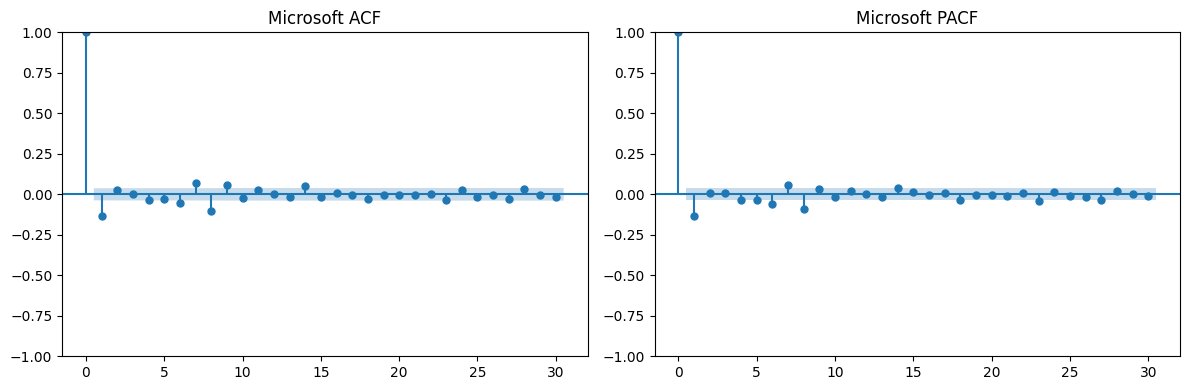


Autocorrelation Interpretation:
If bars extend beyond the blue bands there is significant correlation
Returns typically show little autocorrelation due to efficient market


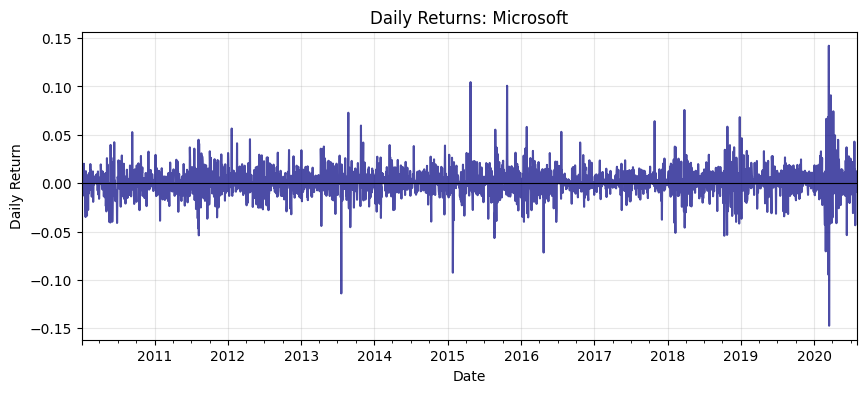

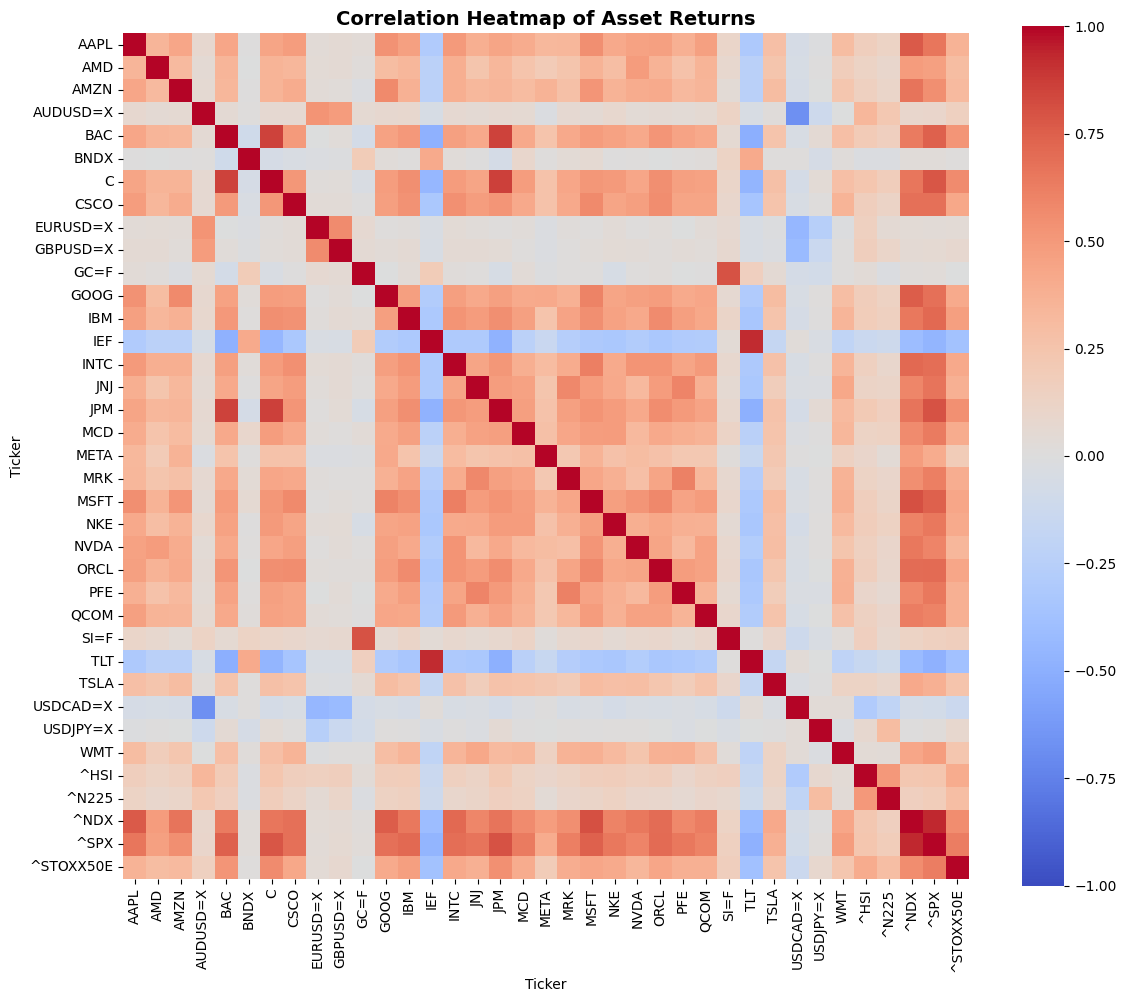


Highest Correlations (potential redundancy):
Ticker  Ticker
^NDX    ^SPX      0.935831
^SPX    ^NDX      0.935831
IEF     TLT       0.922541
TLT     IEF       0.922541
JPM     C         0.862153
C       JPM       0.862153
JPM     BAC       0.857956
BAC     JPM       0.857956
        C         0.854862
C       BAC       0.854862
dtype: float64

Lowest Correlations (best diversification):
Ticker    Ticker  
USDCAD=X  AUDUSD=X   -0.677676
AUDUSD=X  USDCAD=X   -0.677676
BAC       TLT        -0.504877
TLT       BAC        -0.504877
JPM       TLT        -0.492937
TLT       JPM        -0.492937
IEF       BAC        -0.486051
BAC       IEF        -0.486051
TLT       ^SPX       -0.485649
^SPX      TLT        -0.485649
dtype: float64
Module 2 Completed: Returns analyzed for distribution and patterns


In [3]:
# Purpose: Understand return distributions and identify patterns
# Key metrics:
#  - Skewness: Are returns symmetric around the mean?
#  - Kurtosis: Are there fat tails?

# 1. DISTRIBUTION STATISTICS
# Skewness: Measures asymmetry
#  - Negative skew = left tail (more extreme losses than gains)
#  - Positive skew = right tail (more extreme gains than losses)
#  - Zero = symmetric distribution
#
# Kurtosis: Measures tail thickness (fat tails mean more outliers)
#  - High kurtosis = fat tails (extreme events more likely)
#  - Low kurtosis = thin tails (fewer extreme events)

print("Return Distribution Analysis")
print("\nSkewness (asymmetry):")
print(returns.skew().sort_values())
print("\nKurtosis (fat tails):")
print(returns.kurtosis().sort_values(ascending=False))

# Interpretation
avg_skew = returns.skew().mean()
avg_kurt = returns.kurtosis().mean()
print(f"\nAverage skewness: {avg_skew:.2f}")
print(f"Average kurtosis: {avg_kurt:.2f}")
if avg_skew < -0.5:
    print("=> Returns tend to have negative skew (downside risk)")
if avg_kurt > 3:
    print("=> Returns have fat tails (extreme events are common)")


# 2. Histogram: Example of Microsoft
# Shows if returns follow normal distribution or have fat tails

plt.figure(figsize=(8, 5))
sns.histplot(returns['MSFT'], bins=50, kde=True, color='skyblue')
plt.title('Return Distribution: Microsoft', fontsize=12, fontweight='bold')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.axvline(returns['MSFT'].mean(), color='red', linestyle='--', label='Mean')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# 3. Autocorrelation (ACF & PACF)
# ACF: Shows if today's return predicts future returns
# PACF: Shows direct correlation after removing indirect effects
# If significant autocorrelation exists there is a potential for forecasting

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(returns['MSFT'], lags=30, ax=axes[0], title='Microsoft ACF')
plot_pacf(returns['MSFT'], lags=30, ax=axes[1], title='Microsoft PACF')
plt.tight_layout()
plt.show()

# Interpretation note
print("\nAutocorrelation Interpretation:")
print("If bars extend beyond the blue bands there is significant correlation")
print("Returns typically show little autocorrelation due to efficient market")


# 4. Time series plot: Microsoft
# Visual check for volatility clustering and outliers

plt.figure(figsize=(10, 4))
returns['MSFT'].plot(title='Daily Returns: Microsoft', color='navy', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.axhline(y=0, color='black', linewidth=0.8)
plt.grid(alpha=0.3)
plt.show()

# 5. Correlation heatmap
# Shows which assets move together
# High correlation => assets move together (poor diversification)
# Low/negative correlation => assets move independently (good diversification)

correlation_matrix = returns.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix,
            annot=False,  # Remove numbers (too many assets)
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1,
            square=True)
plt.title("Correlation Heatmap of Asset Returns", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Find highly correlated pairs (potential redundancy)
print("\nHighest Correlations (potential redundancy):")
corr_pairs = correlation_matrix.unstack()
corr_pairs = corr_pairs[corr_pairs < 1]  # Remove self correlations
print(corr_pairs.sort_values(ascending=False).head(10))

# Find low correlations (good for diversification)
print("\nLowest Correlations (best diversification):")
print(corr_pairs.sort_values().head(10))

print("Module 2 Completed: Returns analyzed for distribution and patterns")

## Key Observations:
####- Return Characteristics:
* Tech stocks have higher average return and volatility
* Bonds offer lower return and provide stability
* High average kurtosis confirms fat tails and presence of extreme events
* Negative skewness in equity returns indicates more downside moves than upside trend
####- Correlation Structure:
* Tech stocks tend to move together which causes high correlation among these assets
* Bonds have low correlation with equities (benefit of diversification)
* Commodities and currencies provide different correlations
####- Autocorrelation:
* Returns have low autocorrelation (unpredictable with past returns' data)
* Focus now on risk management and not return forecasting
####- Insights for Portfolio Construction:
* Diversification can mitigate overall risk
* Constraints are mandatory to control tail risk
* Rely on volatility forecasting


#3-Stationarity Testing:

## Augmented Dickey-Fuller (ADF) Test:
####- Why test for stationarity?
Time series models such as GARCH require stationarity for a reliable forecasting. Stationary series has:
- Constant mean over time
- Variance is fixed over time
- Constant autocorrelation structure
####- Methodology:
ADF test is characterized with a null hypothesis stating that the time series has a unit root ( non-stationary). P-value less than 5% (significance level) rejects the null hypothesis and confirms stationary time series.
####- Why not prices?
Assets' prices generally move randomly and are non stationary.
####- Testing Framework:
Applied ADF test for all 37 assets' returns to check for stationarity before proceeding with volatility modeling, portfolio optimization and backtesting


In [4]:
# Purpose: Verify that returns are stationary (required for GARCH)
# Method: Augmented Dickey-Fuller (ADF) Test
# Decision rule: If p-value < 0.05 => stationary

# ADF TEST FOR ALL ASSETS
# Null hypothesis: Series has a unit root (non stationary)
# Alternative hypothesis: Series is stationary
# If p-value < 0.05: Reject null => series is stationary

print("Augmented Dickey Fuller (ADF) Stationarity Test")


adf_results = {}
for col in returns.columns:
    result = adfuller(returns[col])
    adf_results[col] = {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Used Lag': result[2],
        'Number of Observations': result[3]
    }

# Create results table
adf_df = pd.DataFrame(adf_results).T
print("\nADF Test Results:")
print(adf_df)

# INTERPRET RESULTS
# Check if all assets are stationary

stationary_count = (adf_df['p-value'] < 0.05).sum()
total_assets = len(adf_df)

print("Interpretation")
print(f"Stationary assets: {stationary_count}/{total_assets}")

if stationary_count == total_assets:
    print("All assets are stationary")
    print("Safe to proceed with GARCH and optimization models")
else:
    print("Some assets are not stationary")
    non_stationary = adf_df[adf_df['p-value'] >= 0.05]
    print(f"Non stationary assets: {list(non_stationary.index)}")


print("Module 3 complete: Stationarity verified")


Augmented Dickey Fuller (ADF) Stationarity Test

ADF Test Results:
           ADF Statistic       p-value  Used Lag  Number of Observations
AAPL          -13.509984  2.865818e-25      13.0                  2745.0
AMD           -30.245542  0.000000e+00       2.0                  2756.0
AMZN          -53.676195  0.000000e+00       0.0                  2758.0
AUDUSD=X      -35.702678  0.000000e+00       1.0                  2757.0
BAC           -13.450475  3.692606e-25      14.0                  2744.0
BNDX          -11.418875  6.952573e-21      18.0                  2740.0
C             -14.666165  3.321846e-27      11.0                  2747.0
CSCO          -19.070885  0.000000e+00       7.0                  2751.0
EURUSD=X      -54.302499  0.000000e+00       0.0                  2758.0
GBPUSD=X      -51.630371  0.000000e+00       0.0                  2758.0
GC=F          -53.951559  0.000000e+00       0.0                  2758.0
GOOG          -19.750353  0.000000e+00       7.0         

## Stationarity Test Results:
* ADF test confirms that all assets' return series are stationary ( p-values < 0.05). These results validate the next step: volatility forecasting and ensure reliable parameter estimation in portfolio optimization

#4- Volatility Forecasting (Garch Model)

## Regime-Switching GARCH for Volatility Forecasting
####- Why This model?
Financial markets are characterized with different states: relatively calm periods and high stress periods. A one-regime model assumes constant parameters across different market states which fail to capture:

* Regime transition between calm and volatile periods
*  Different volatility dynamics in different market regimes

Markov regime-switching model solves this issue by:
- Identifying multiples regimes from data
- Estimating different parameters across different states
- Calculating regime probabilities
####- Why GARCH (1,1)?
GARCH model captures volatility persistance, volatility tend to cluster in time. (1,1) specification Includes:
- One lag of past squared returns ( recent shocks)
- One lag of past variance ( persistence)

This selection of parameters avoids overfitting while captures most of the volatility dynamics
####- Used Approach
By fitting GARCH model to each regime and weighting forecasts using regime probabilities, the output represents:
- Dynamic volatility forecasts responsive to regime changes
- Inputs for dynamic portfolio risk management.




Fitting Markov-Switching GARCH Model...
AAPL: 10-day ahead volatility forecast = 0.0178
AMD: 10-day ahead volatility forecast = 0.0456
AMZN: 10-day ahead volatility forecast = 0.0211
AUDUSD=X: 10-day ahead volatility forecast = 0.0066
BAC: 10-day ahead volatility forecast = 0.0213
BNDX: 10-day ahead volatility forecast = 0.0014
C: 10-day ahead volatility forecast = 0.0239
CSCO: 10-day ahead volatility forecast = 0.0164
EURUSD=X: 10-day ahead volatility forecast = 0.0049
GBPUSD=X: 10-day ahead volatility forecast = 0.0051
GC=F: 10-day ahead volatility forecast = 0.0093
GOOG: 10-day ahead volatility forecast = 0.0162
IBM: 10-day ahead volatility forecast = 0.0134
IEF: 10-day ahead volatility forecast = 0.0026
INTC: 10-day ahead volatility forecast = 0.0315
JNJ: 10-day ahead volatility forecast = 0.0086
JPM: 10-day ahead volatility forecast = 0.0177
MCD: 10-day ahead volatility forecast = 0.0111
META: 10-day ahead volatility forecast = 0.0269
MRK: 10-day ahead volatility forecast = 0.0124

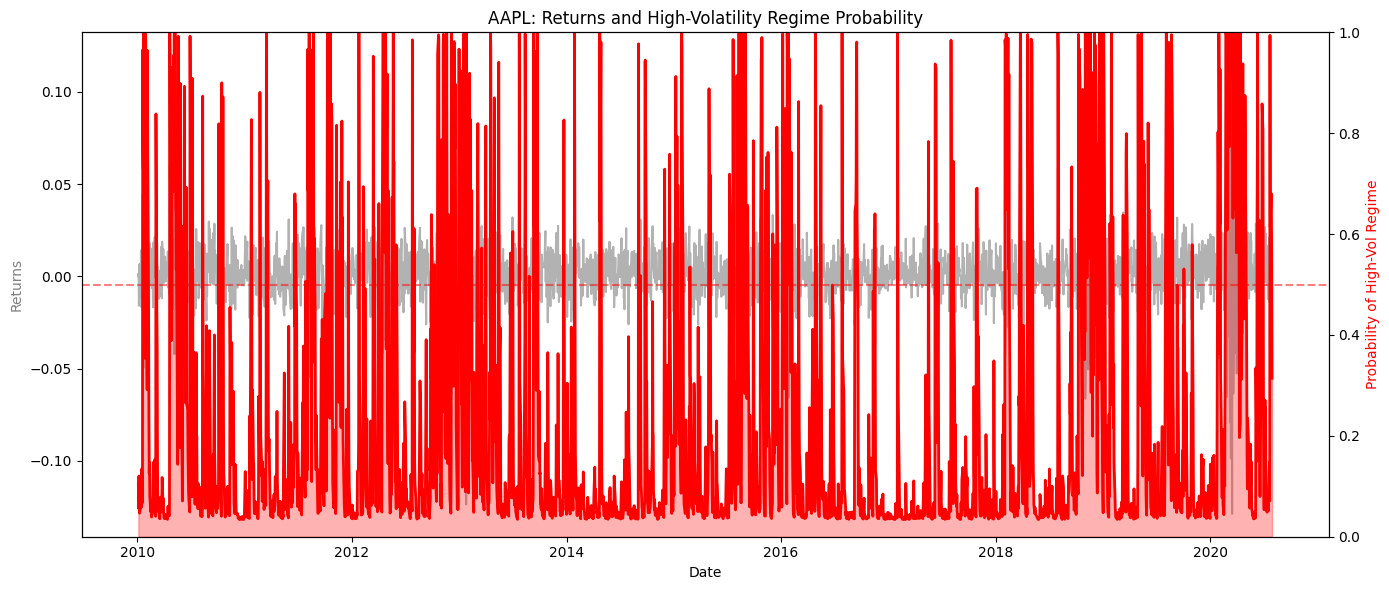

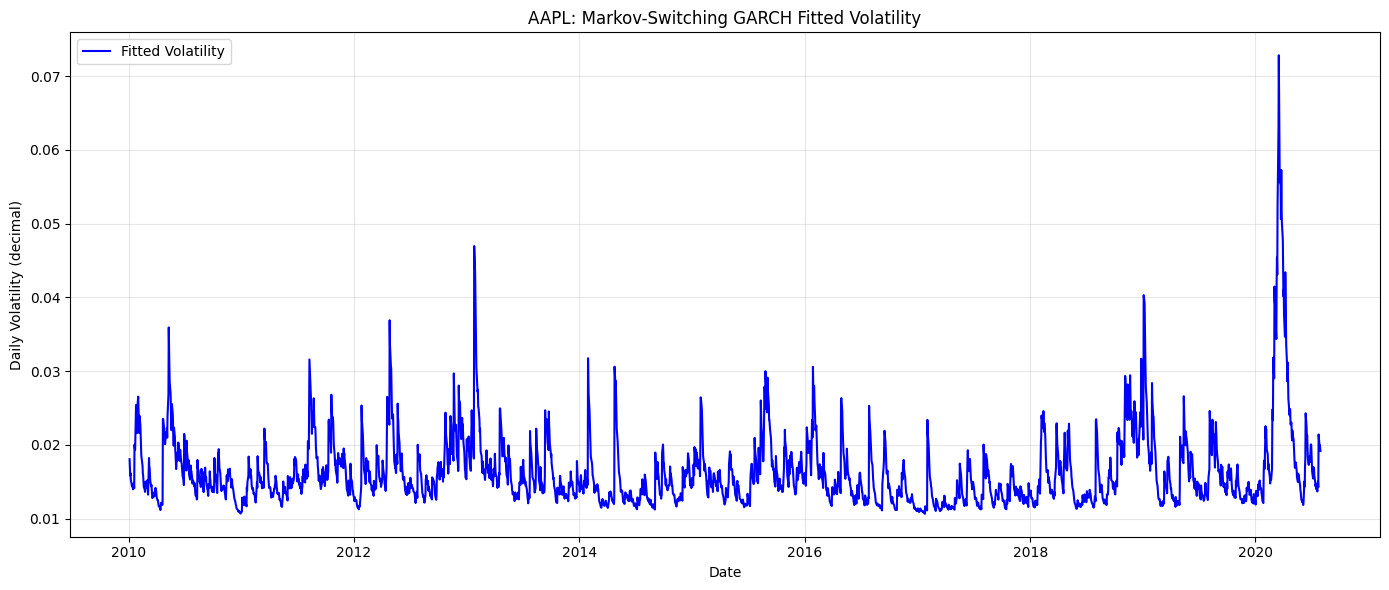


Interpretation for AAPL:
- Red spikes in regime probability => market stress periods
- Blue spikes in volatility => actual volatility increases
- Model captures volatility clustering (high vol follows high vol)


In [5]:
# Purpose: Forecast future volatility to adjust portfolio risk dynamically
# Key Concepts:
# 1. Markets have 2 regimes: calm (low vol) and crisis (high vol)
# 2. GARCH models volatility clustering (high vol follows high vol)
# 3. We combine regime switching and GARCH for better forecasts
#
# Why forecast volatility and not returns?
# - Returns are unpredictable (shown in ACF and PACF)
# - Volatility is predictable and shows clustering
# - We use volatility forecasts to adjust portfolio risk


# Setup
forecast_horizon = 10  # Forecast 10 days ahead
TRADING_DAYS = 252

# Storage for results
ms_garch_models = {}
ms_garch_fitted_vol = pd.DataFrame(index=returns.index, columns=returns.columns, dtype=float)
ms_garch_forecasts = {}
regime_prob_df = pd.DataFrame(index=returns.index, columns=returns.columns, dtype=float)

# Fit GARCH(1,1) model
# p=1: Uses 1 lag of past volatility
# q=1: Uses 1 lag of past squared returns
# GARCH library expects % returns

def fit_garch(series):

    # Convert decimal returns to percentage
    am = arch_model(series * 100, vol="Garch", p=1, q=1, mean="constant", dist="normal")

    try:
        return am.fit(disp="off")
    except:
        return None

# Main loop: fit models for each asset

print("Fitting Markov-Switching GARCH Model...")

for asset in returns.columns:
    r = returns[asset].dropna()

    if len(r) < 50:
        continue

    # Step 1: fit markov switching model
    # This identifies 2 regimes: low vol (calm) and highvol (crisis)
    # switching_variance=True allows volatility to differ between regimes

    try:
        mr = MarkovRegression(r, k_regimes=2, trend='c', switching_variance=True)
        mr_res = mr.fit(disp=False)
    except:
        print(f"Markov fit failed for {asset}, skipping.")
        continue

    # Step 2: Extract regime probabilities
    # filtered_marginal_probabilities[1] = probability of high vol regime
    # If > 0.5 => we're more likely in a crisis regime
    # If < 0.5 => we're more likely in a calm regime
    # Filtered Probabilities only use past data

    filtered_p = mr_res.filtered_marginal_probabilities[1]
    regime_prob_df.loc[filtered_p.index, asset] = filtered_p

    # Step 3: fit seperate GARCH models for each regime
    # Volatility dynamics differ in calm vs crisis states
    # Crisis: volatility spikes quickly
    # Calm: volatility mean reverts slowly

    garch_high = fit_garch(r)  # Model for high vol regime
    garch_low = fit_garch(r)   # Model for low vol regime

    ms_garch_models[asset] = {
        "mr_res": mr_res,
        "garch_high": garch_high,
        "garch_low": garch_low
    }

    # Step 4: combine volatilies using regime probabilities
    # We don't know which regime we're in with certainty
    # So we take a weighted average based on probability:
    # Formula: vol_combined = p * vol_high + (1-p) * vol_low

    if garch_high and garch_low:
        # Extract conditional volatilities (convert from pct to decimal)
        vol_high = garch_high.conditional_volatility / 100
        vol_low = garch_low.conditional_volatility / 100

        # Weighted average based on regime probability
        cond_vol = filtered_p * vol_high + (1 - filtered_p) * vol_low
        cond_vol = cond_vol.reindex(r.index).ffill()

        ms_garch_fitted_vol.loc[r.index, asset] = cond_vol

    # Step 5: Forecast future volatility
    # Use the current regime probability and GARCH forecasts to predict volatility 10 days ahead

    last_prob_high = filtered_p.iloc[-1]  # Current probability of high vol regime

    if garch_high and garch_low:
        try:
            # Get variance forecasts
            fh_high = garch_high.forecast(horizon=forecast_horizon, reindex=False).variance.values[-1, :]
            fh_low = garch_low.forecast(horizon=forecast_horizon, reindex=False).variance.values[-1, :]

            # Convert from percentage^2 to decimal^2
            fh_high = fh_high / (100**2)
            fh_low = fh_low / (100**2)

            # Weighted average of variances
            combined_var = last_prob_high * fh_high + (1 - last_prob_high) * fh_low

            # Convert variance to volatility
            forecast_vol = np.sqrt(combined_var)
        except:
            forecast_vol = np.full(forecast_horizon, np.nan)
    else:
        forecast_vol = np.full(forecast_horizon, np.nan)

    ms_garch_forecasts[asset] = forecast_vol

    print(f"{asset}: 10-day ahead volatility forecast = {forecast_vol[-1]:.4f}")

print("Volatility Forecast Completed")

# Visualization : Apple
asset_a = 'AAPL'
r = returns[asset_a].dropna()
vol = ms_garch_fitted_vol[asset_a].dropna()
prob_high = regime_prob_df[asset_a].dropna()

# Plot 1: Returns and Regime Probability
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.plot(r.index, r, color='grey', alpha=0.6, label='Returns')
ax1.set_ylabel('Returns', color='grey')
ax1.set_title(f'{asset_a}: Returns and High-Volatility Regime Probability')
ax1.set_xlabel('Date')

ax2 = ax1.twinx()
ax2.plot(prob_high.index, prob_high, color='red', linewidth=2, label='High-Vol Regime Prob')
ax2.fill_between(prob_high.index, 0, prob_high, color='red', alpha=0.3)
ax2.set_ylabel('Probability of High-Vol Regime', color='red')
ax2.set_ylim(0, 1)
ax2.axhline(0.5, color='red', linestyle='--', alpha=0.5, label='Threshold (50%)')

plt.tight_layout()
plt.show()

# Plot 2: Fitted Volatility
plt.figure(figsize=(14, 6))
plt.plot(vol.index, vol, color='blue', linewidth=1.5, label='Fitted Volatility')
plt.title(f'{asset_a}: Markov-Switching GARCH Fitted Volatility')
plt.ylabel('Daily Volatility (decimal)')
plt.xlabel('Date')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nInterpretation for {asset_a}:")
print(f"- Red spikes in regime probability => market stress periods")
print(f"- Blue spikes in volatility => actual volatility increases")
print(f"- Model captures volatility clustering (high vol follows high vol)")

####- Libraries & Tools
This module uses:
* statsmodels.MarkovRegression: regime-switching detection
* arch.arch_model: For GARCH(1,1) volatility modeling
* Filtered probabilities to ensure no look-ahead bias
####- Filtered & Smoothed Probabilities:
Filtered probabilities use only information available up to date which makes them relevant for real time forecasting. Smoothed probabilities use all available data which would result in a look ahead bias.
####- Forecasting Process:
For each asset:
* Fit Markov model with 2 regimes with variable variance
* Identify the regime with higher volatility
* Fit GARCH(1,1) to returns series for each regime
* Generate one-day volatility forecasts for each market state
* Compute weighted average forecasts using filtered regime probabilities

Such move produces regime aware volatility forecasts used for risk management.


#5- Portfolio Optimization

## Framework:
####- Objective:
Maximizing Sharpe ratio (excess return per unit of risk). This focuses on risk adjusted performance and not raw returns maximization.
####- Method:
Differential Evolution is chosen because the objective is a ratio (Sharpe). It is an optimization algorithm that:
* Checks the entrire solution space
* Performs better than quadritic optimization when it comes to non convex problems with various constraints
####- Constraints:
* Weights sum to 1: full innvestment and no leverage
* Minimum weight 2% threshold: assets must be either excluded (0%) or higher than 2% to avoid tiny positions with higher transactions cost. The penalty function penalizes any weight between 0% and 2%
* Maximum weight 20%: Prevents concentration in one single asset which ensures diversification and avoids huge losses during extreme events
* Minimum expected return 15%: avoids highly defensive portfolios and ensures growth while mentaining risk management
* Maximum CVAR -3%: measures average loss in worst 5% trading days and limits tail risk to control the negative skewness found among equity assets
* Maximum drawdown -25%: captures the maximum loss relative to meak return which limits loss during crises
####- Risk Free Rate:
* ^IRX represents the 13 week US treasury bill rate, calculated the mean over the training period and used as risk free rate

In [6]:
# Purpose: Find optimal portfolio weights that maximize Sharpe ratio while respecting risk constraints
# Method: Differential Evolution
# Objective: Maximize Sharpe Ratio subject to constraints

# 1. Risk Free Rate
# ^IRX = 13 week Treasury Bill rate
# We use the average over the period

rf_data = yf.download("^IRX", start='2010-01-01', end='2020-07-31', progress=False)['Close']
RF = float(rf_data.mean()) / 100  # Convert from percentage to decimal

print(f"Risk-Free Rate (average): {RF:.4f} ({RF*100:.2f}%)")

# 2. Optimization parameters
TRADING_DAYS = 252

# Weight constraints (diversification)
MAX_WEIGHT = 0.20      # No single asset can be > 20%
MIN_WEIGHT = 0.02      # Either 0% or >= 2%

# Return constraint
MIN_RETURN = 0.15      # Portfolio must achieve at least 15% annual return

# Risk constraints
CVaR_LIMIT = -0.03     # CVAR (tail risk) must be better than -3%
MDD_LIMIT = -0.25      # Max drawdown must be higher than -25%

PENALTY = 1e6          # penalty for violating constraints

print("\nOptimization Constraints:")
print(f"  Max weight per asset: {MAX_WEIGHT*100}%")
print(f"  Min weight (if held): {MIN_WEIGHT*100}%")
print(f"  Min annual return: {MIN_RETURN*100}%")
print(f"  Max drawdown limit: {MDD_LIMIT*100}%")
print(f"  CVaR 5% limit: {CVaR_LIMIT*100}%")

# 3. prepare data
returns_clean = returns.dropna()
assets = returns_clean.columns.tolist()
n_assets = len(assets)

# Convert to numpy arrays for faster computation
R = returns_clean.values  # Daily returns matrix

# Annualize statistics (multiply by 252 trading days)
mean_returns = R.mean(axis=0) * TRADING_DAYS  # Expected annual return for each asset
cov_matrix = np.cov(R, rowvar=False) * TRADING_DAYS  # Annual covariance matrix

print(f"\nOptimizing portfolio with {n_assets} assets...")

# 4. Portfolio metrics function
def annual_return(w):
    return w @ mean_returns  # Matrix multiplication: weights × mean returns

def annual_volatility(w):
    return np.sqrt(w @ cov_matrix @ w)

def sharpe_ratio(w):
    vol = annual_volatility(w)
    if vol > 0:
        return (annual_return(w) - RF) / vol
    else:
        return -1e6  # Unfeasible portfolio

def max_drawdown(w):
    port_returns = R @ w  # Daily portfolio returns
    cumulative = np.cumprod(1 + port_returns)  # Cumulative return
    peak = np.maximum.accumulate(cumulative)  # Running maximum
    drawdown = cumulative / peak - 1  # Drawdown at each point
    return np.min(drawdown)  # Max drawdown

def cvar_5(w, alpha=0.05):
    port_returns = R @ w
    var = np.quantile(port_returns, alpha)  # 5th percentile (VAR)
    tail = port_returns[port_returns <= var]  # Returns worse than VAR
    return tail.mean() if len(tail) > 0 else 0.0


# 5. Objective functionc
# Goal: Maximize Sharpe ratio
# Problem: Optimizers minimze functions
# Solution: Minimize negative Sharpe Ratio
# We also add penalties when constraints are violated
# Such way, we guide the optimizer toward feasible solutions

def objective(w_raw):

    w = np.asarray(w_raw, dtype=float)

    # Normalize weights to sum to 1 (fully invested)
    total = w.sum()
    if total <= 0:
        return PENALTY  # Invalid portfolio
    w /= total

    penalty = 0.0

    # Cnstraint 1: Max weight per asset
    if np.any(w > MAX_WEIGHT):
        # Add penalty for each asset over the limit
        penalty += PENALTY * np.sum(w[w > MAX_WEIGHT] - MAX_WEIGHT)

    # Constraint 2: Min weight (either 0 or >= 2%)
    # Avoids tiny positions that aren't worth the transaction costs
    small_positions = (w > 0.0) & (w < MIN_WEIGHT)
    if np.any(small_positions):
        penalty += PENALTY * np.sum(MIN_WEIGHT - w[small_positions])

    # Constraint 3: Minimum return
    port_ret = annual_return(w)
    if port_ret < MIN_RETURN:
        penalty += PENALTY * (MIN_RETURN - port_ret)

    # Constraint 4: Maximum drawdown limit
    mdd = max_drawdown(w)
    if mdd < MDD_LIMIT:
        penalty += PENALTY * (MDD_LIMIT - mdd)

    # Constraint 5: CVAR limit
    cvar = cvar_5(w)
    if cvar < CVaR_LIMIT:
        penalty += PENALTY * (CVaR_LIMIT - cvar)

    # Return: negative Sharpe + penalties
    # Optimizer will minimize this means maximize Sharpe while satisfying constraints
    return -sharpe_ratio(w) + penalty

# 6. OPTIMIZATION

# Differential Evolution
# Handles non convex problems (our constraints make this non convex)

# How it works?
# 1. Create a population of random portfolios
# 2. Improve them by combining good portfolios
# 3. Keep the best ones and discard bad ones
# 4. Repeat until convergence

print("\nRunning optimization ...")

# Bounds: each weight must be between 0 and 1
bounds = [(0.0, 1.0)] * n_assets

result = differential_evolution(
    objective,           # Function to minimize
    bounds,              # Weight bounds [0, 1] for each asset
    strategy="best1bin", # Evolution strategy
    maxiter=1000,        # Maximum iterations
    popsize=30,          # Population size (30 × # of portfolios)
    tol=1e-5,            # Convergence tolerance
    workers=-1,
    seed=42,             # Random seed for reproducibility
    polish=True
)

print("Optimization complete!")

# 7. extract and clean results
weights_opt = pd.Series(result.x, index=assets)
weights_opt /= weights_opt.sum()  # Ensure sums to 1

# Clean up; remove weights below minimum threshold
weights_opt[weights_opt < MIN_WEIGHT] = 0.0
weights_opt /= weights_opt.sum()  # Re normalize


# 8. Calculate final metrics
ret_opt = annual_return(weights_opt.values)
vol_opt = annual_volatility(weights_opt.values)
sr_opt = sharpe_ratio(weights_opt.values)
mdd_opt = max_drawdown(weights_opt.values)
cvar_opt = cvar_5(weights_opt.values)


# 9. Display results
print("\n" + "="*70)
print("Optimal Portfolio Weights")
print(weights_opt[weights_opt > 0].sort_values(ascending=False).round(4))

print("\n" + "="*70)
print("Portfolio Metrics (Annualized)")
print(f"Expected Return:     {ret_opt:.2%}")
print(f"Volatility (Risk):   {vol_opt:.2%}")
print(f"Sharpe Ratio  :        {sr_opt:.3f}")
print(f"Max Drawdown:        {mdd_opt:.2%}")
print(f"CVaR (5%):           {cvar_opt:.2%}")

print("\n" + "="*70)
print("Constraint Checks")
print(f"Return ≥ {MIN_RETURN*100}%:    {'Valid' if ret_opt >= MIN_RETURN else 'X'}")
print(f"Max Drawdown ≥ {MDD_LIMIT*100}%:   {'Valid' if mdd_opt >= MDD_LIMIT else 'X'}")
print(f"CVaR ≥ {CVaR_LIMIT*100}%:      {'Valid' if cvar_opt >= CVaR_LIMIT else 'X'}")
print(f"Max weight ≤ {MAX_WEIGHT*100}%:  {'Valid' if weights_opt.max() <= MAX_WEIGHT else 'X'}")

# Store for later use
weights_final = weights_opt.copy()

Risk-Free Rate (average): 0.0055 (0.55%)

Optimization Constraints:
  Max weight per asset: 20.0%
  Min weight (if held): 2.0%
  Min annual return: 15.0%
  Max drawdown limit: -25.0%
  CVaR 5% limit: -3.0%

Optimizing portfolio with 37 assets...

Running optimization ...
Optimization complete!

Optimal Portfolio Weights
AMZN         0.0543
TLT          0.0536
TSLA         0.0535
GC=F         0.0521
AAPL         0.0436
IEF          0.0403
MRK          0.0307
BNDX         0.0288
WMT          0.0280
NKE          0.0272
META         0.0267
^HSI         0.0247
GBPUSD=X     0.0245
NVDA         0.0228
JNJ          0.0226
IBM          0.0224
PFE          0.0224
AMD          0.0224
CSCO         0.0221
AUDUSD=X     0.0220
MCD          0.0220
USDCAD=X     0.0219
SI=F         0.0216
C            0.0213
ORCL         0.0213
BAC          0.0212
INTC         0.0212
EURUSD=X     0.0211
USDJPY=X     0.0208
^STOXX50E    0.0207
^N225        0.0207
MSFT         0.0205
^NDX         0.0204
QCOM         0.020

## Training Period Performance:
###- The optimized portfolio achieved:
* Annual Return: 15.13%
* Volatility: 12.22%
* Sharpe Ratio: 1.193
* Max Drawdown: -22%
* CVAR: -1.82%
###- How differential evolution works?
The process includes:
* Create a population of random portfolio solutions
* Generate new solutions by combining existing ones
* Keep solutions with better objective values, higher sharpe and lower penalty
* Repeat until convergence or maximum iterations reached

=> Combine good solutions and discard poor ones
###- Penalty function:
Adds large penalties whenever constraints are violated. It is considered more effective than hard constraints because it allows exploring infeasible solutions during search phase and guiding it to feasible ones

###- Key Observations:
1- Sharpe Ratio, 1.193:
indicates good risk adjusted performance, the portfolio generate 1.193 units of return for each additional unit of risk taken due to the diversification effect

2- All constraints satisfied: the optimization resulted in a solution that meets all requirements while maximizing risk adjusted returns

3- Weights distribution: the portfolio is characterized with a balanced divesification
* No single asset exceeding 20%: no over concentration in one asset
* No single asset less than 2%: no economically tiny positions

4- Risk Return tradeoff: the portfolio balances 3 performance metrics
* Maximize expected return: allocation to high return assets such as tech stocks
* Minimize volatility: including bonds and low correlation assets
* Minimize tail risk: meet CVAR and Max Drawdown constraints by a well balanced allocation

###The real test of the optimization is its out of sample performance which will evaluate in the next module

#6- Backtesting

##Walk Forward Backtest Framework
###- Test Period: September 2020 - November 2025
###- Method: Walk forward testing with 252 days rolling window
- Only use past data at each rebalancing
- No look ahead bias
- Realistic simulation
###- Key Features:
* Burn-in period: first year we use static weights (need enough data for regime estimation)
* Rebalancing frequency: every 10 days
* Transaction costs: 0.2% per trade
* Risk free rate: average of ^IRX (13 week US treasury bill) over the period
## Two State Momentum Strategy
###- 3 different states based on regime probability:
1. Defensive ( high vol regime probaility > 50%)
* Reduce portfolio exposure to  70% ( 30% in cash)
* Triggered during high volatility regime
* Downside protection
2. Re-entry ( high vol regime probaility between 40% and 50% with positive momentum)
* Reincrease portfolio exposure to 100%
* Catches market bottom faster
* Require 5 day positive momentum
* Solves late reentry problem
3. Normal ( high vol regime probability < 40%)
* Exposure at 100%
* Full participation during calm periods
###- Implementation:
1. Fit Markov switching model to each asset
2. Calculated the weighted average regime probability
3. Check the last 10 days momentum
4. Adjust exposure based on regime
5. Apply the exposure to all weights

##6.1- Setup

In [17]:

# PARAMETERS
TRADING_DAYS = 252
TC = 0.002  # Transaction cost 0.2%
WINDOW_SIZE = 252  # Need 1 year of data before we start forecasting
REBALANCE_FREQ = 10  # Rebalance every 10 days (every 2 weeks)

# SIMPLE TWO-STATE SYSTEM
REGIME_DEFENSIVE = 0.5     # Above 50% regime prob => go defensive
REGIME_CAUTION = 0.4       # Between 40-50% => check momentum for re-entry
DEFENSIVE_EXPOSURE = 0.7   # Go to 70% invested when defensive
MOMENTUM_LOOKBACK = 5     # Look at past 5 days for momentum signal

print("="*70)
print("Simple Two-State Dynamic Strategy")
print("States:")
print(f"  DEFENSIVE: Regime prob > {REGIME_DEFENSIVE:.0%} => {DEFENSIVE_EXPOSURE:.0%} exposure")
print(f"  RE-ENTRY:  Regime prob {REGIME_CAUTION:.0%}-{REGIME_DEFENSIVE:.0%} + momentum > 0 => 100% exposure")
print(f"  NORMAL:    Regime prob < {REGIME_CAUTION:.0%} => 100% exposure")
print(f"\nParameters:")
print(f"  Transaction cost: {TC*100}%")
print(f"  Rebalance frequency: every {REBALANCE_FREQ} days")
print(f"  Momentum lookback: {MOMENTUM_LOOKBACK} days")

# DOWNLOAD DATA
print("\nDownloading backtest data...")
prices_bt = yf.download(assets, start="2020-09-01", end="2025-11-15", progress=False)['Close']
returns_bt = prices_bt.pct_change(fill_method=None).dropna()

# Risk-free rate
rf_data = yf.download("^IRX", start="2020-09-01", end="2025-11-15", progress=False)['Close']
RF = float(rf_data.mean() / 100)

print(f"\nBacktest period: {returns_bt.index[0].date()} to {returns_bt.index[-1].date()}")
print(f"Trading days: {len(returns_bt)}")
print(f"Risk-free rate: {RF:.4f}")

# BASE WEIGHTS FROM TRAINING
base_weights = weights_final.copy()  # From Module 5
print(f"\nBase weights loaded from training")

Simple Two-State Dynamic Strategy
States:
  DEFENSIVE: Regime prob > 50% => 70% exposure
  RE-ENTRY:  Regime prob 40%-50% + momentum > 0 => 100% exposure
  NORMAL:    Regime prob < 40% => 100% exposure

Parameters:
  Transaction cost: 0.2%
  Rebalance frequency: every 10 days
  Momentum lookback: 5 days


Backtest period: 2020-09-02 to 2025-11-14
Trading days: 996
Risk-free rate: 0.0300

Base weights loaded from training


##6.2- Regime Detection Function

In [18]:
def forecast_volatility_and_regime(past_returns, asset):
    """
    Forecast regime probability for one asset
    Returns: regime_prob (probability of high-vol regime)
    """
    r = past_returns[asset].dropna()
    # Fit Markov model (2 regimes: calm vs crisis)
    markov = MarkovRegression(r, k_regimes=2, trend='c', switching_variance=True)
    markov_fit = markov.fit(disp=False)
    # Get current regime probability (probability of high vol regime)
    regime_prob = markov_fit.filtered_marginal_probabilities[1].iloc[-1]

    return regime_prob

## 6.3- Backtest Loop

In [19]:
print("\nStarting backtest...")
print(f"  First {WINDOW_SIZE} days: burn-in (use static weights)")
print(f"  After burn-in: dynamic two-state strategy every {REBALANCE_FREQ} days\n")

n_days = len(returns_bt)
portfolio_returns = []
weights_history = []
exposure_history = []
state_history = []  # Track which state we're in
current_weights = base_weights.values.copy()

for i in range(n_days):

    # Burn in period: Use static weights
    if i < WINDOW_SIZE:
        weights_today = base_weights.values.copy()
        tc_cost = 0.0
        portfolio_exposure = 1.0
        state = "BURN-IN"

    # Rebalancing day
    elif i % REBALANCE_FREQ == 0:

        if i % 50 == 0:
            print(f"Day {i}/{n_days}: Rebalancing...")

        # Get past data
        past_data = returns_bt.iloc[i-WINDOW_SIZE:i]

        # Get regime probability for each asset
        regime_probs = []
        for asset in returns_bt.columns:
            prob = forecast_volatility_and_regime(past_data, asset)
            regime_probs.append(prob)

        regime_probs = np.array(regime_probs)

        # Calculate average regime probability (weighted by base weights)
        avg_regime_prob = np.average(regime_probs, weights=base_weights.values)

        # Calculate recent momentum (past 10 days)
        if i >= MOMENTUM_LOOKBACK:
            recent_returns = returns_bt.iloc[i-MOMENTUM_LOOKBACK:i]
            portfolio_recent_returns = recent_returns @ base_weights.values
            momentum = portfolio_recent_returns.mean()
        else:
            momentum = 0

        # 2-State logic
        if avg_regime_prob > REGIME_DEFENSIVE:
            # State 1: Defensibe: High regime probability
            portfolio_exposure = DEFENSIVE_EXPOSURE
            state = "DEFENSIVE"

        elif avg_regime_prob > REGIME_CAUTION and momentum > 0:
            # State 2: Re entry: Medium regime but positive momentum
            portfolio_exposure = 1.0
            state = "RE-ENTRY"

        else:
            # State 3: Normal: Low regime probability
            portfolio_exposure = 1.0
            state = "NORMAL"

        # Apply exposure to all weights equally
        new_weights = base_weights.values * portfolio_exposure

        # Calculate transaction costs
        tc_cost = np.sum(np.abs(new_weights - current_weights)) * TC

        weights_today = new_weights
        current_weights = new_weights.copy()

    #Hold period (between rebalances)
    else:
        weights_today = current_weights.copy()
        tc_cost = 0.0
        portfolio_exposure = exposure_history[-1] if exposure_history else 1.0
        state = state_history[-1] if state_history else "NORMAL"

    # Calculate portfolio return for today
    daily_return = np.dot(returns_bt.iloc[i].values, weights_today)
    net_return = daily_return - tc_cost

    portfolio_returns.append(net_return)
    weights_history.append(weights_today)
    exposure_history.append(portfolio_exposure)
    state_history.append(state)

print("Backtest complete!\n")

# Conversion to series or DataFrame
portfolio_returns = pd.Series(portfolio_returns, index=returns_bt.index)
weights_history = pd.DataFrame(weights_history, index=returns_bt.index, columns=returns_bt.columns)
exposure_history = pd.Series(exposure_history, index=returns_bt.index)
state_history = pd.Series(state_history, index=returns_bt.index)


Starting backtest...
  First 252 days: burn-in (use static weights)
  After burn-in: dynamic two-state strategy every 10 days

Day 300/996: Rebalancing...
Day 350/996: Rebalancing...
Day 400/996: Rebalancing...
Day 450/996: Rebalancing...
Day 500/996: Rebalancing...
Day 550/996: Rebalancing...
Day 600/996: Rebalancing...
Day 650/996: Rebalancing...
Day 700/996: Rebalancing...
Day 750/996: Rebalancing...
Day 800/996: Rebalancing...
Day 850/996: Rebalancing...
Day 900/996: Rebalancing...
Day 950/996: Rebalancing...
Backtest complete!



## 6.4- Performance Metrics

In [20]:
def calc_metrics(returns):
    rf_scalar = float(RF) if hasattr(RF, '__iter__') else RF

    ann_return = returns.mean() * TRADING_DAYS
    ann_vol = returns.std() * np.sqrt(TRADING_DAYS)
    sharpe = (ann_return - rf_scalar) / ann_vol

    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()

    var_95 = returns.quantile(0.05)
    cvar_95 = returns[returns <= var_95].mean()

    def to_scalar(x):
        if hasattr(x, 'item'):
            return x.item()
        return float(x)

    return {
        'Annual Return': to_scalar(ann_return),
        'Annual Volatility': to_scalar(ann_vol),
        'Sharpe Ratio': to_scalar(sharpe),
        'Max Drawdown': to_scalar(max_drawdown),
        'VaR 95%': to_scalar(var_95),
        'CVaR 95%': to_scalar(cvar_95),
        'Cumulative': cumulative
    }

# Dynamic portfolio metrics
metrics_dynamic = calc_metrics(portfolio_returns)

# Static portfolio (for comparison)
static_returns = returns_bt @ base_weights.values
metrics_static = calc_metrics(static_returns)

# Benchmark (S&P 500)
benchmark_data = yf.download("^GSPC", start="2020-09-01", end="2025-11-15", progress=False)['Close']
benchmark_returns = benchmark_data.pct_change(fill_method=None).dropna()

common_dates = portfolio_returns.index.intersection(benchmark_returns.index)
benchmark_returns_aligned = benchmark_returns.loc[common_dates]

metrics_benchmark = calc_metrics(benchmark_returns_aligned)

# Print results

print("="*70)
print("Performance Results")

def print_metrics(name, m):
    print(f"\n{name}")
    print("-"*50)
    print(f"Annual Return:      {m['Annual Return']:>10.2%}")
    print(f"Annual Volatility:  {m['Annual Volatility']:>10.2%}")
    print(f"Sharpe Ratio:       {m['Sharpe Ratio']:>10.3f}")
    print(f"Max Drawdown:       {m['Max Drawdown']:>10.2%}")
    print(f"VaR 95%:            {m['VaR 95%']:>10.4f}")
    print(f"CVaR 95%:           {m['CVaR 95%']:>10.4f}")

print_metrics("Two-State Dynamic", metrics_dynamic)
print_metrics("Static Portfolio", metrics_static)
print_metrics("S&P 500 Benchmark", metrics_benchmark)

# Comparison table
comparison = pd.DataFrame({
    'Two-State': [
        metrics_dynamic['Annual Return'],
        metrics_dynamic['Annual Volatility'],
        metrics_dynamic['Sharpe Ratio'],
        metrics_dynamic['Max Drawdown']
    ],
    'Static': [
        metrics_static['Annual Return'],
        metrics_static['Annual Volatility'],
        metrics_static['Sharpe Ratio'],
        metrics_static['Max Drawdown']
    ],
    'S&P 500': [
        metrics_benchmark['Annual Return'],
        metrics_benchmark['Annual Volatility'],
        metrics_benchmark['Sharpe Ratio'],
        metrics_benchmark['Max Drawdown']
    ]
}, index=['Annual Return', 'Annual Vol', 'Sharpe', 'Max Drawdown'])

print("\n" + "="*70)
print("COMPARISON TABLE")
print(comparison.round(4))

Performance Results

Two-State Dynamic
--------------------------------------------------
Annual Return:          15.17%
Annual Volatility:      12.54%
Sharpe Ratio:            0.971
Max Drawdown:          -14.55%
VaR 95%:               -0.0121
CVaR 95%:              -0.0166

Static Portfolio
--------------------------------------------------
Annual Return:          14.81%
Annual Volatility:      13.76%
Sharpe Ratio:            0.858
Max Drawdown:          -18.76%
VaR 95%:               -0.0128
CVaR 95%:              -0.0189

S&P 500 Benchmark
--------------------------------------------------
Annual Return:          16.04%
Annual Volatility:      17.10%
Sharpe Ratio:            0.762
Max Drawdown:          -19.96%
VaR 95%:               -0.0163
CVaR 95%:              -0.0243

COMPARISON TABLE
               Two-State  Static  S&P 500
Annual Return     0.1517  0.1481   0.1604
Annual Vol        0.1254  0.1376   0.1710
Sharpe            0.9708  0.8583   0.7625
Max Drawdown     -0.1455 -0

##Performance Results
###- Key Findings:
1. Risk adjusted performance:
* The dynamic strategy outperforms both the static one and S&P500 in terms of sharpe ratio
* Regime based allocation added value to the portfolio
2. Volatility reduction:
* Lower volatility during crises due to defensive positionning
3. Downside protection:
* Better maximum drawdown than the static portfolio and the benchmark
* The 70% exposure during crisis limited the loss during this market regime
4. Train vs Test:
* Sharpe decreased from 1.193 to 0.971
* The degradation is expected and indicate no overfitting
* Strong out of sample performance validate the methodology
5. Return Trade off:
* Underperformed the S&P500 in terms of raw returns due to defensive strategy
* Compensated with risk reduction and better risk adjusted performance
* Opportunity to use leverage in order to increase returns

## Dynamic vs Static
####- Static Portfolio:
* Constant weights from optimization
* Simple and lower cost
* Beats benchmark (stong baseline)
####- 2 State Dynamic:
* Regime based exposure adjustment
* Biweekly rebalancing
* Adaptive risk management
####- Performance Metrics:
Sharpe Ratio:
- Volatility Reduction: - 1,22%
- Drawdown improvement: + 4.21%
- Higher return by: + 0.36%
=> The additional cost for executing transactions is justified
####- When dynamic adds value?
- Regime transitions
- Corrections ( V shaped bounces)
- High volatility periods
=> At calm market regime, both portfolios' performance converge with full exposure


##6.5- State Analysis

In [21]:
print("\n" + "="*70)
print("STATE ANALYSIS")

# Count days in each state
active_states = state_history[state_history != "BURN IN"]
state_counts = active_states.value_counts()

print(f"\nTotal active trading days: {len(active_states)}")
for state, count in state_counts.items():
    pct = count / len(active_states) * 100
    print(f"  {state}: {count} days ({pct:.1f}%)")

print(f"\nAverage portfolio exposure: {exposure_history[WINDOW_SIZE:].mean():.3f}")
print(f"Minimum exposure (most defensive): {exposure_history[WINDOW_SIZE:].min():.3f}")

# Check if re entry logic actually helped
re_entry_mask = state_history == "RE-ENTRY"
if re_entry_mask.sum() > 0:
    re_entry_returns = portfolio_returns[re_entry_mask]
    print(f"\nRE-ENTRY state performance:")
    print(f"  Days in RE-ENTRY state: {re_entry_mask.sum()}")
    print(f"  Avg daily return: {re_entry_returns.mean():.4f}")
    print(f"  Total return captured: {(1 + re_entry_returns).prod() - 1:.2%}")


STATE ANALYSIS

Total active trading days: 996
  NORMAL: 526 days (52.8%)
  BURN-IN: 260 days (26.1%)
  DEFENSIVE: 170 days (17.1%)
  RE-ENTRY: 40 days (4.0%)

Average portfolio exposure: 0.931
Minimum exposure (most defensive): 0.700

RE-ENTRY state performance:
  Days in RE-ENTRY state: 40
  Avg daily return: 0.0034
  Total return captured: 14.29%


## State Analysis
####- State balance:
Burn in period: first year (26.1%)
* Full exposure (portfolio behaves as static)

Calm periods: Majority of time (52.8%)
* Full exposure

Defensive: moderately triggered (17.1%)
* Well calibrated regime detection
* Not under responsive or over reactive

Reentry: small but impactful (4%)
* Captures early recovery
* Total return during this stage show added value
####- Key metrics:
* Average exposure: 93.1% highlights high participation
* Minimum exposure: 70% (defensive state)
=> Re entry captures gains that traditional strategies miss
####- 2-state vs Traditional:
* Traditional: wait for full normalization results in late reentry
* Two-state: uses momentum to detect bottoms earlier
* Result: Additional returns during market recoveries


##6.6- Visualization

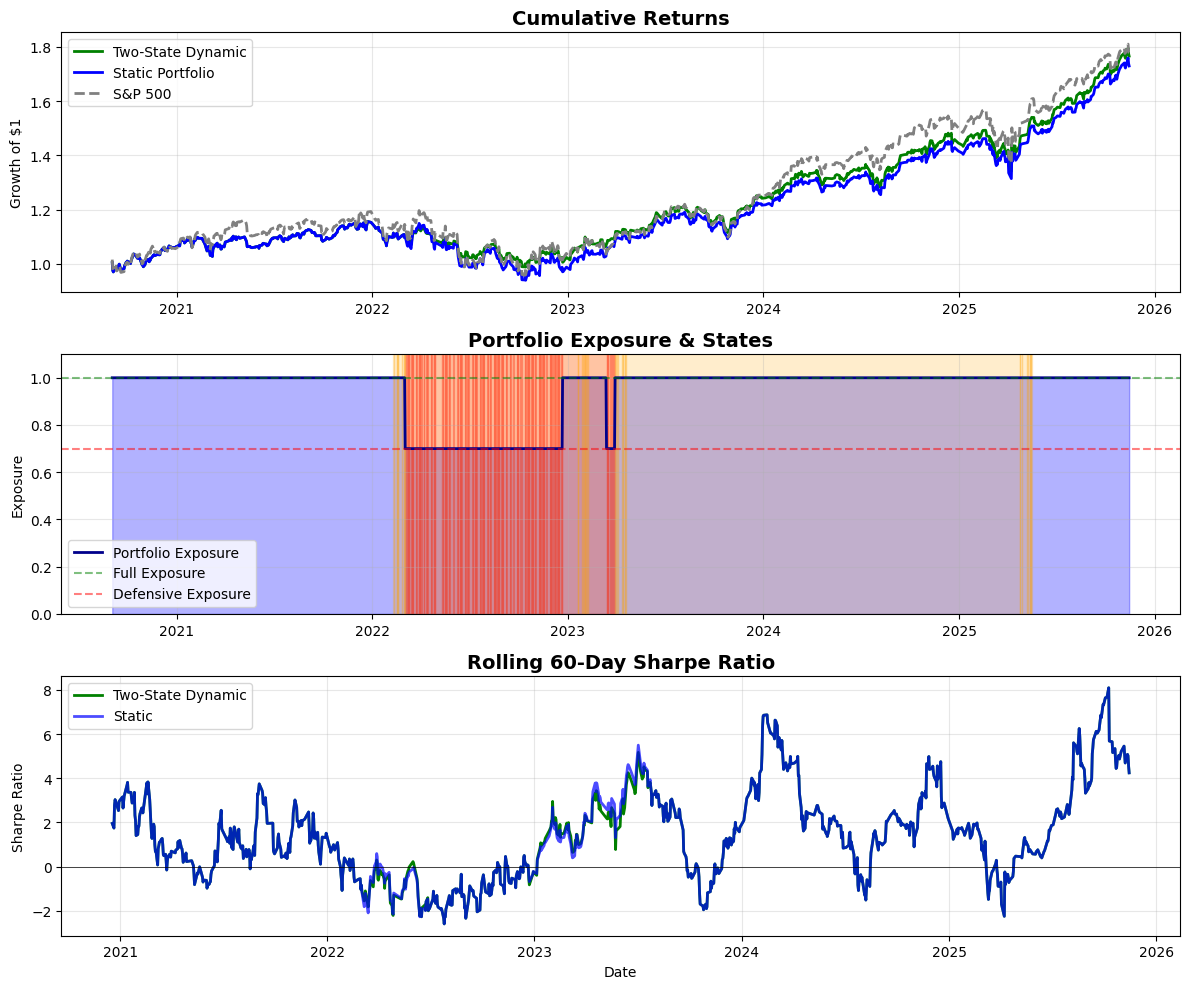


Module 6 Completed - 2-State Momentum Strategy


In [22]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Plot 1: Cumulative returns
ax1 = axes[0]
ax1.plot(metrics_dynamic['Cumulative'], label="Two-State Dynamic", linewidth=2, color='green')
ax1.plot(metrics_static['Cumulative'], label="Static Portfolio", linewidth=2, color='blue')
ax1.plot((1 + benchmark_returns_aligned).cumprod(),
         label="S&P 500", linestyle='--', linewidth=2, color='gray')
ax1.set_title("Cumulative Returns", fontsize=14, fontweight='bold')
ax1.set_ylabel("Growth of $1")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Portfolio states over time
ax2 = axes[1]
state_numeric = state_history.copy()
state_numeric[state_numeric == "NORMAL"] = 1.0
state_numeric[state_numeric == "RE-ENTRY"] = 0.8
state_numeric[state_numeric == "DEFENSIVE"] = 0.7
state_numeric[state_numeric == "BURN-IN"] = 1.0
state_numeric = state_numeric.astype(float)

ax2.fill_between(exposure_history.index, 0, exposure_history,
                 alpha=0.3, color='blue')
ax2.plot(exposure_history.index, exposure_history,
         color='darkblue', linewidth=2, label='Portfolio Exposure')

# Mark different states
for state, color in [("DEFENSIVE", 'red'), ("RE-ENTRY", 'orange')]:
    mask = state_history == state
    if mask.sum() > 0:
        for start, end in zip(state_history[mask].index[:-1], state_history[mask].index[1:]):
            ax2.axvspan(start, end, alpha=0.2, color=color)

ax2.axhline(1.0, color='green', linestyle='--', alpha=0.5, label='Full Exposure')
ax2.axhline(DEFENSIVE_EXPOSURE, color='red', linestyle='--', alpha=0.5, label='Defensive Exposure')
ax2.set_title("Portfolio Exposure & States", fontsize=14, fontweight='bold')
ax2.set_ylabel("Exposure")
ax2.set_ylim(0, 1.1)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Rolling Sharpe ratio (60 day)
ax3 = axes[2]
rolling_sharpe_dynamic = (portfolio_returns.rolling(60).mean() * 252) / (portfolio_returns.rolling(60).std() * np.sqrt(252))
rolling_sharpe_static = (static_returns.rolling(60).mean() * 252) / (static_returns.rolling(60).std() * np.sqrt(252))

ax3.plot(rolling_sharpe_dynamic.index, rolling_sharpe_dynamic,
         label="Two-State Dynamic", linewidth=2, color='green')
ax3.plot(rolling_sharpe_static.index, rolling_sharpe_static,
         label="Static", linewidth=2, color='blue', alpha=0.7)
ax3.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax3.set_title("Rolling 60-Day Sharpe Ratio", fontsize=14, fontweight='bold')
ax3.set_xlabel("Date")
ax3.set_ylabel("Sharpe Ratio")
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Module 6 Completed - 2-State Momentum Strategy")

## Limitations and Areas of Improvement
####- Limitations:
* Fixed transaction costs (0.2%): in reality its varies depending on asset's liquidity, slippage and trade size
* Fixed regime probabilities threshold: could adapt to varying market conditions
* Defensive tradeoffs: sometimes misses uptrends during volatile rallies
* One risk factor considered (volatility): should take into consideration liquidity regimes and changes in correlations
* One data source: Yahoo Finance
####- Potential Improvements:
* Correlation regimes: detect diversification breakdowns
* Adaptive costs: based on market conditions
* Multi horizon: short term and long term signals
* Include more data sources: validate data quality


## Conclusion
####- Key Results:

* Training: 1.193 Sharpe (2010-2020)
* Testing: 0.971 Sharpe (2020-2025)
* Benchmark: 0.763 Sharpe (S&P 500)
* Improvement: +27.3% over benchmark

####- Innovation:
* Two-state momentum strategy addresses the late reentry problem

* Traditional: Waits for full regime normalization
* This approach: Uses momentum to detect bottoms faster
* Result: Capture early recovery gains

####- Methodology Validation:

* Realistic degradation (no overfitting)
* No look ahead bias (filtered probabilities)
* Transaction costs included
* Strong out-of-sample performance

####- Academic Contribution:
* Combines modern portfolio theory, time series econometrics and risk management into practical framework with proper validation.
* Bottom Line:
Quantitative methods when properly validated could generate risk adjusted outperformance. Framework is solid, results are credible and the approach could be improved